In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import sys
import time
import matplotlib.pyplot as plt
from iforest import IsolationTreeEnsemble, find_TPR_threshold

### Problem

The dataset cancer.csv contains 569 patients medical tests infomation and diagnosis of whether they have cancer or not. Here we treated the patients with cancer (diagnosis equals 1) as anomoly points in our dataset. Then we can fit an isolation tree model and use the model for future prediction.

### Import Data

In [26]:
df1 = pd.read_csv("../data/cancer.csv")

In [27]:
df1.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


* Features in the dataset

In [28]:
df1.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'diagnosis'],
      dtype='object')

* labels 

In [29]:
df1.diagnosis.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Here the 0 means without cancer and 1 means with cancer

### Fit the Isolation forest model

In [30]:
X, y = df1.drop('diagnosis', axis=1), df1['diagnosis']

In [31]:
# add noise to the dataset
def add_noise(df):
    n_noise = 5
    for i in range(n_noise):
        df[f'noise_{i}'] = np.random.normal(0,100,len(df))
add_noise(df1)

In [39]:
it = IsolationTreeEnsemble(sample_size=5, n_trees=1000)

#fit the model using improved method
fit_start = time.time()
it.fit(X, improved=True)
fit_stop = time.time()
fit_time = fit_stop - fit_start
print(f"INFO {'cancer.csv'} fit time {fit_time:3.2f}s")

#calculate total nodes in the trained isolation forested
n_nodes = sum([t.n_nodes for t in it.trees])
print(f"INFO {'cancer.csv'} {n_nodes} total nodes in {1000} trees")

#predict
score_start = time.time()
scores = it.anomaly_score(X)
score_stop = time.time()
score_time = score_stop - score_start
print(f"INFO {'cancer.csv'} score time {score_time:3.2f}s")

#evaluate the model
threshold, FPR = find_TPR_threshold(y, scores, 0.75)

y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
confusion = confusion_matrix(y, y_pred)
TN, FP, FN, TP = confusion.flat
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
print(f"SUCCESS {'cancer.csv'} {1000} trees at desired TPR {0.75*100.0:.1f}% getting FPR {FPR*100:.4f}%")

INFO cancer.csv fit time 0.16s
INFO cancer.csv 5882 total nodes in 1000 trees
INFO cancer.csv score time 0.90s
SUCCESS cancer.csv 1000 trees at desired TPR 75.0% getting FPR 14.8459%


### Model Evaluation

In [40]:
confusion

array([[304,  53],
       [ 48, 164]])

From this confusion matrixs, we can see that 
* The False positive is 60, which means 53 people are wrongly diagonised with cancer. 
* The False negative is 50, which means 48 people are wrongly diagonised without cancer.
* The False positive rate is 14.85%
* Precision is 86.36%
* Recall is 85.15%
* Accuracy is 82.24%

Text(0.491,20,'score threshold:0.49')

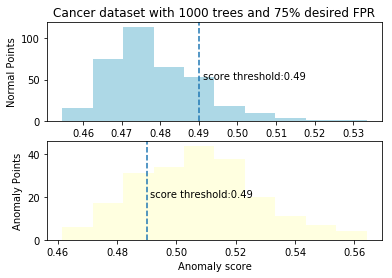

In [74]:
plt.subplot(2,1,1)
plt.hist(scores[df1.diagnosis==0], color='lightblue')
plt.title('Cancer dataset with 1000 trees and 75% desired FPR')
plt.ylabel('Normal Points')
plt.xlabel('Anomaly Score')
plt.axvline(x=threshold, linestyle='--')
plt.text(threshold+0.001, 50, 'score threshold:{:.2f}'.format(threshold))

plt.subplot(2,1,2)
plt.hist(scores[df1.diagnosis==1], color='lightyellow')
plt.ylabel('Anomaly Points')
plt.xlabel('Anomaly score')
plt.axvline(x=threshold, linestyle='--')
plt.text(threshold+0.001, 20, 'score threshold:{:.2f}'.format(threshold))

### Summary

* The isolation forest algorithm is original and beautiful in its simplicity; and also seems to work very well with our example datasets.
* The improved version of the algorithm is more robust to noisy features in the dataset.
* To improve the model, we can train hyper parameters by changing the number of trees and changing the threshhold.